Carga de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from yaml import safe_load
from sklearn.linear_model import LinearRegression

Definición de rutas relativas del archivo

In [2]:
ROOT = os.path.dirname(os.getcwd())
DATA = os.path.join(ROOT, 'data')

Carga de archivo de configuración

In [3]:
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as file:
    CONFIG = safe_load(file)
file.close()

# 1. Resultados de un examen para niños

La siguiente sección está basada en el capítulo 3 de _Data Analysis using Regression and Hierarquical Models_ de Andrew Gelman y Jennifer Hill. La secuencia de los ejercicios en el _notebook_ va en el orden de aparición de los ejemplos en el libro.

## 1.1. Predictor binario

Para predictores binarios, los coeficientes de regresión lienal represetan la diferencia entre los promedios de dos grupos. Considera el ejemplo en el que se modela los resultados de una prueba de niños, y se proporciona como variable indicadora si sus madres tienen estudios de secundaria ($mother_{hs}$).

Para ilustrarlo, primero se describen brevemente los datos:

In [4]:
# Ruta a archivo de datos
file_name = os.path.join(DATA, 'kid_iq.csv')

# Carga de datos en un dataframe
kid_iq = pd.read_csv(file_name)

# Eliminar columnas sin nombre
kid_iq.drop(
    columns=[col for col in kid_iq.columns if col.startswith('Unnamed')]
    ,inplace=True)

# Descripción básica de los datos
kid_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   kid_score  434 non-null    int64  
 1   mom_hs     434 non-null    int64  
 2   mom_iq     434 non-null    float64
 3   mom_work   434 non-null    int64  
 4   mom_age    434 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 17.1 KB


Ahora se entrena el modelo de regresión lineal y se generan datos

In [5]:
# Definición de datos para el modelo
x_train = kid_iq.mom_hs.to_numpy().reshape((-1,1))
y_train = kid_iq.kid_score.to_numpy().reshape((-1,1))

# Iniciar instancia de modelo de regresión lineal
lin_reg = LinearRegression(
    fit_intercept=True)

# Entrenamiento de modelo
lin_reg.fit(
    X=x_train
    ,y=y_train)

# Coeficientes del modelo
lin_reg.intercept_, lin_reg.coef_

(array([77.5483871]), array([[11.771261]]))

El modelo que describe los resultados quedaría dado por la expresión:

$$score = 78 + 12 mother_{hs}$$

Este modelo resumen la diferencia entre el resultado promedio de los niños cuya madre no tuvo estudios de secundaria, contra el resultado promedio de aquellos niños cuya madre sí tuvo estudios.

Con el modelo anterior, es posible simular respuestas ante entradas determinadas:

In [6]:
x_pred = np.linspace(start=0, stop=1, num=100).reshape((-1,1))
y_pred = lin_reg.predict(x_pred)

Se puede visualizar el comporamiento del resultado de la prueba condicionado a si la madre concluyó estudios de secundaria, junto con el modelo que describe su comportamiento

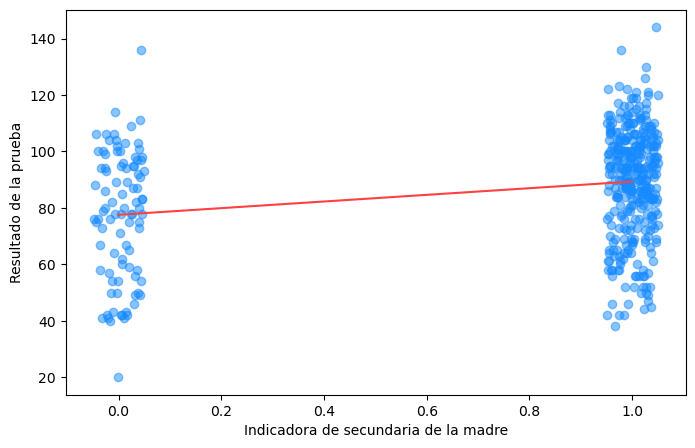

In [7]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.scatter(
    x=kid_iq.mom_hs + np.random.uniform(low=-0.05, high=0.05, size=kid_iq.shape[0])
    ,y=kid_iq.kid_score
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

ax.plot(
    x_pred, y_pred
    ,color=CONFIG['graficas']['colors']['rojo'])

# Anotaciones y estilo
ax.set_xlabel('Indicadora de secundaria de la madre')
ax.set_ylabel('Resultado de la prueba')

plt.show()

## 1.2. Predictor continuo

Ahora se investiga cuál es el comportamiento de una variable predictora que es continua, por ejemplo, el IQ de la madre. Nuevamente se hace el entrenamiento del modelo para obtener los coeficientes de regresión lineal:

In [8]:
# Definición de datos para el modelo
x_train = kid_iq.mom_iq.to_numpy().reshape((-1,1))
y_train = kid_iq.kid_score.to_numpy().reshape((-1,1))

# Iniciar instancia de modelo de regresión lineal
lin_reg = LinearRegression(
    fit_intercept=True)

# Entrenamiento de modelo
lin_reg.fit(
    X=x_train
    ,y=y_train)

# Coeficientes del modelo
lin_reg.intercept_, lin_reg.coef_

(array([25.79977785]), array([[0.60997457]]))

En esta ocasión vemos que el modelo de regresión lineal que describe el comporamiento de los datos en función del IQ de la madre está dado por:

$$score = 26 + 0.6 mother_{iq}$$

Con el cual se pueden hacer predicciones:

In [9]:
x_pred = np.linspace(start=70, stop=150, num=100).reshape((-1,1))
y_pred = lin_reg.predict(X=x_pred)

Nuevamente, se puede visualizar el comportamiento del modelo:

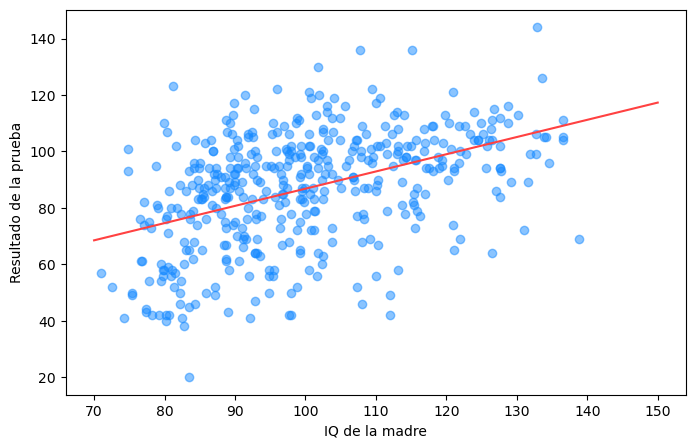

In [10]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
ax.scatter(
    x=kid_iq.mom_iq
    ,y=kid_iq.kid_score
    ,color=CONFIG['graficas']['colors']['azul']
    ,alpha=0.5)

ax.plot(
    x_pred, y_pred
    ,color=CONFIG['graficas']['colors']['rojo'])

# Anotaciones y estilo
ax.set_xlabel('IQ de la madre')
ax.set_ylabel('Resultado de la prueba')

plt.show()

## 1.3. Predictores múltiples

A medida que va aumentando el número de predictores lineales, la interpretación de la regresión lineal se empieza a volver más compleja debido a que su interpretación está sujeta al valor de los demás coeficientes. Tomar por ejemplo el caso en el que se mezclan los dos predictores anteriores, es decir, tanto el IQ como la indicador de secundaria de la madre:

Como en los ejemplos anteriores, se empieza por redefinir el modelo de regresión lineal:

In [11]:
# Definición de datos para el modelo
x_train = kid_iq[['mom_hs', 'mom_iq']].to_numpy()
y_train = kid_iq.kid_score.to_numpy().reshape((-1,1))

# Iniciar instancia de regresión lineal
lin_Reg = LinearRegression(
    fit_intercept=True)

# Entrenamiento
lin_reg.fit(
    X=x_train
    ,y=y_train)

# Coeficientes del modelo
lin_reg.intercept_, lin_reg.coef_

(array([25.73153818]), array([[5.95011691, 0.56390605]]))

Lo cual resulta en el modelo de regresión lineal:

$$score = 26 + 6 mother_{hs} + 0.6 mother_{iq}$$

En este modelo, para una adecuada interpretación de los coeficientes, y dado que se tiene una variable binaria junto con una variable continua, entonces se tendría que estratificar el modelo por la variable binaria.

In [12]:
# Se hacen predicciones sobre los datos observados
y_pred = lin_reg.predict(X=x_train)

df = kid_iq[['mom_hs','mom_iq','kid_score']].copy()
df['kid_score_hat'] = y_pred

Finalmente, visualizamos los datos estratificando por la indicadora de secundaria de la madre:

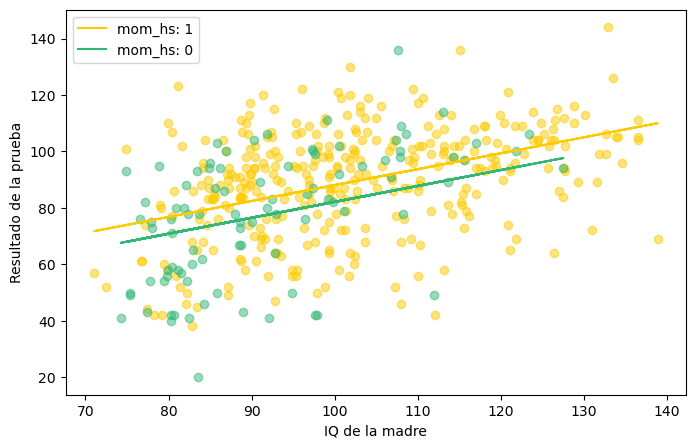

In [13]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
for mom_hs in df.mom_hs.unique():
    _df = df.query(f"mom_hs == {mom_hs}")

    ax.scatter(
        x=_df.mom_iq
        ,y=_df.kid_score
        ,alpha=0.5
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])
    
    ax.plot(
        _df.mom_iq
        ,_df.kid_score_hat
        ,label=f'mom_hs: {mom_hs}'
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])

# Anotaciones y estilo
ax.set_xlabel('IQ de la madre')
ax.set_ylabel('Resultado de la prueba')
ax.legend()

plt.show()

La forma de interpretarlo entonces es la siguiente:

* _Intercepto_: Si la madre tiene un IQ de 0, y no tuvo estudios de secundaria, entonces el resultado esperado para el niño sería de 26 puntos.
* _Coeficiente de indicadora de secundaria de la madre_: Comparando a los niños cuyas madres tienen el mismo IQ pero estratificando por la indicadora de secundaria, el modelo predice una diferencia esperada de 6 puntos en el resultado da las pruebas.
* _Coefieciente de IQ de la madre_: Comparando a los niños cuyas madres se encuentran en el mismo grupo de indicadora de secundaria pero cuyos IQ's difieren en 1 punto, entonces el modelo predice una diferencia esperada de 0.6 puntos en el resultado de las pruebas.

## 1.4. Interacciones entre variables

No siempre será posible mantener constante una variable explicativa para aislar el efecto que tiene sobre la variable respuesta, tal es el caso de modelos que incorporan el efecto de variables lineales o elevadas a alguna potencia, así como el caso de interacciones.

Se puede retomar el ejemplo visto hasta ahora incorporando la interacción entre el IQ y la indicadora de secundaria de la madre.

In [14]:
# Definición de datos para el modelo
x_train = (
    kid_iq[['mom_hs', 'mom_iq']]
    .copy()
    .assign(
        mom_hs_iq = lambda _df: _df.mom_hs * _df.mom_iq)
).to_numpy()

y_train = kid_iq.kid_score.to_numpy().reshape((-1,1))

# Iniciar instancia de modelo
lin_reg = LinearRegression(
    fit_intercept=True)

# Entrenamiento
lin_reg.fit(
    X=x_train
    ,y=y_train)

# Coeficientes del modelo
lin_reg.intercept_, lin_reg.coef_

(array([-11.48202114]), array([[51.26822343,  0.96888921, -0.48427467]]))

Lo cual resulta en el siguiente modelo de regresión lineal:

$$score = -11 + 51 mother_{hs} + 0.9 mother_{iq} - 0.5 mother_{hs}\cdot mother_{iq}$$

Con el cual se pueden hacer predicciones sobre los datos de entrenamiento:

In [15]:
df = (
    kid_iq[['mom_hs', 'mom_iq', 'kid_score']]
    .copy()
    .assign(
        kid_score_hat = lin_reg.predict(X=x_train))
)

Finalmente, visualizamos los datos estratificando por la indicadora de secundaria de la madre:

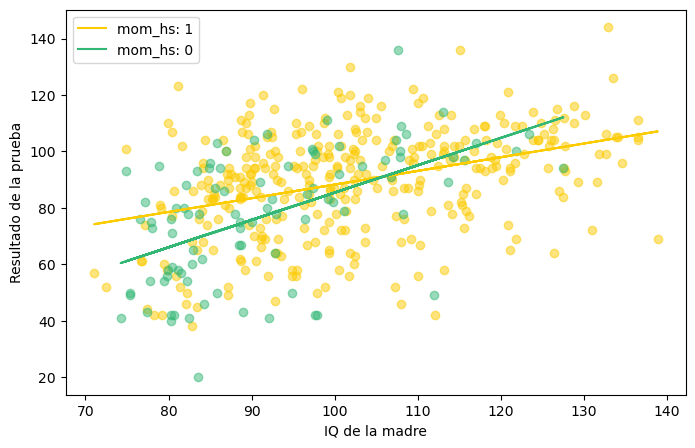

In [16]:
# Configuraciones de figura
fig, ax = plt.subplots(figsize = (8,5))

# Elementos de visualización
for mom_hs in df.mom_hs.unique():
    _df = df.query(f"mom_hs == {mom_hs}")

    ax.scatter(
        x=_df.mom_iq
        ,y=_df.kid_score
        ,alpha=0.5
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])
    
    ax.plot(
        _df.mom_iq
        ,_df.kid_score_hat
        ,label=f'mom_hs: {mom_hs}'
        ,color=list(CONFIG['graficas']['colors'].values())[mom_hs])

# Anotaciones y estilo
ax.set_xlabel('IQ de la madre')
ax.set_ylabel('Resultado de la prueba')
ax.legend()

plt.show()

Observamos que claramente existe una diferencia en la pendiente del modelo cuando se estrátifica por la indicadora de secundaria de la madre, cuando se incorpora al modelo la interacción entre ambas.

# 2. Antes y después del entrenamiento

La siguiente sección está basada en el capítulo 4 de _Data Analysis using Regression and Hierarquical Models_ de Andrew Gelman y Jennifer Hill.

El ejercicio tomado es _Predicting yields of mesquite bushes_ de la sección 4.6

In [17]:
mesquite = pd.read_csv(os.path.join(DATA, 'mesquite.csv'))
mesquite.head()

,Obs,Group,Diam1,Diam2,TotHt,CanHt,Dens,LeafWt
0,1,MCD,1.8,1.15,1.30,1.00,1,401.3
1,2,MCD,1.7,1.35,1.35,1.33,1,513.7
2,3,MCD,2.8,2.55,2.16,0.60,1,1179.2
3,4,MCD,1.3,0.85,1.80,1.20,1,308.0
4,5,MCD,3.3,1.90,1.55,1.05,1,855.2


Lo primero que se puede probar es entrenar un modelo sin realizar ningún tipo de conversión en los datos, para eso se puede considerar los siguiente:

In [18]:
# Definición de datos para el modelo
x_train = (
    mesquite[['Diam1', 'Diam2', 'CanHt', 'TotHt', 'Dens', 'Group']]
    .assign(
        Group = lambda df: pd.Categorical(df.Group, categories=['MCD','ALS']).codes)
)
x_train = sm.add_constant(data=x_train)

y_train = mesquite.LeafWt

# Iniciar instancia de modelo
lin_reg = sm.OLS(y_train, x_train)

# Entrenamiento y resumen
results = lin_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LeafWt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     36.34
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.73e-14
Time:                        16:44:11   Log-Likelihood:                -318.82
No. Observations:                  46   AIC:                             651.6
Df Residuals:                      39   BIC:                             664.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -728.5929    147.159     -4.951      0.000   -1026.250    -430.935
Diam1        189.6690    112.760      1.682      0.101     -38.410     417.748
Diam2        371.4621    124.378      2.987      0.005     119.883     623.041
CanHt        355.6653    209.843      1.695      0.098     -68.782     780.113
TotHt       -101.7325    185.574     -0.548      0.587    -477.091     273.626
Dens         131.2542     34.355      3.820      0.000      61.764     200.744
Group       -363.2951    100.184     -3.626      0.001    -565.936    -160.654
==============================================================================
Omnibus:                        9.865   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               19.723
Skew:                           0.366   Prob(JB):                     5.21e-05
Kurtosis:                       6.123   Cond. No.                         26.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lin_reg.